# Formdeskriptoren basierend auf Nachbarschaftsgraphen
Dieses Notebook zeigt, wie man Formdeskriptoren von Zellen bestimmen kann, wenn sie nicht genau segmentiert werden können, aber ihre Zentren erkannt werden können.

In [1]:
from skimage.measure import regionprops
import numpy as np
import pyclesperanto_prototype as cle

cle.get_device()

<gfx90c on Platform: AMD Accelerated Parallel Processing (2 refs)>

Wir erzeugen ein Labelbild von Zellen mit gegebenen Größen in x und y und einem Größenverhältnis von 1:1,5.

Nehmen wir an, dies ist das Ergebnis eines Zellsegmentierungsalgorithmus.

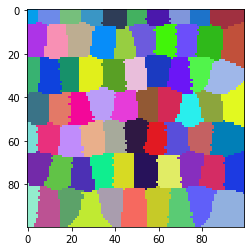

In [2]:
cell_size_x = 10
cell_size_y = 15

# generate and show tissue
tissue_labels = cle.artificial_tissue_2d(width=100, height=100, delta_x=cell_size_x, delta_y=cell_size_y, random_sigma_x=1, random_sigma_y=1)
cle.imshow(tissue_labels, labels=True)

# Klassische Formdeskriptoren: kleine und große Achse
Wir können die kleine und große Achse dieser Zellen mit scikit-image messen

In [3]:
label_image = cle.pull_zyx(tissue_labels).astype(int)

stats = regionprops(label_image)

avg_minor_axis_length = np.mean([s.minor_axis_length for s in stats])
print("Durchschnittliche Länge der kleinen Achse", avg_minor_axis_length)

avg_major_axis_length = np.mean([s.major_axis_length for s in stats])
print("Durchschnittliche Länge der großen Achse", avg_major_axis_length)

Average minor axis length 11.094738115993875
Average major axis length 16.966309163176998


Wir erzeugen nun ein Bild, bei dem die Zellen möglicherweise schwer zu segmentieren sind, z.B. ein Membranbild.

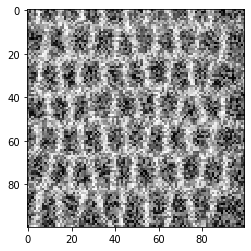

In [4]:
cell_borders = cle.detect_label_edges(label_image)

convolved_membranes = cle.gaussian_blur(cell_borders, sigma_x=1, sigma_y=2)

noise_level = 3
noise = (np.random.random(convolved_membranes.shape) - 0.5) * cle.mean_of_all_pixels(convolved_membranes) * noise_level
noise = noise.astype(np.float32)

artifical_membrane_image = (convolved_membranes + noise)

cle.imshow(artifical_membrane_image)

## Formdeskriptoren basierend auf Nachbarschaftsnetzen
In manchen Fällen können wir die Zellen nicht richtig segmentieren, wir können nur eine Punkterkennung durchführen und die Zentren der Zellen visualisieren.

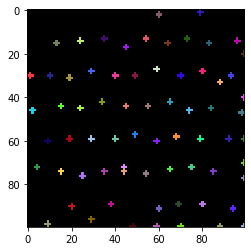

In [5]:
blurred = cle.gaussian_blur(artifical_membrane_image, sigma_x=2, sigma_y=2)

local_minima = cle.detect_minima_box(blurred)

spot_image = cle.label_spots(local_minima)

# we extend the spots a little bit for visualization purposes
spot_image = cle.maximum_sphere(spot_image, radius_x=1, radius_y=1)

cle.imshow(spot_image, labels=True)

Aus einem solchen Bild von markierten Punkten können wir ein Voronoi-Diagramm erstellen, in dem wir analysieren können, welche Zellen (erweiterte Punkte) nahe beieinander liegen.

Das Ergebnis ist eine Annäherung an die Zellsegmentierung.

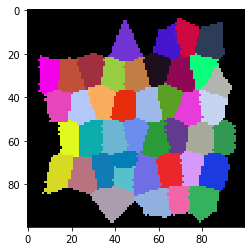

In [6]:
voronoi_diagram_all = cle.extend_labeling_via_voronoi(spot_image)

# exclude labels on image edges
voronoi_diagram = cle.exclude_labels_on_edges(voronoi_diagram_all)

cle.imshow(voronoi_diagram, labels=True)

Aus einem solchen Paar von Punktbild und Voronoi-Diagramm können wir zwei Matrizen ableiten: eine Berührungsmatrix (auch bekannt als Adjazenzgraphmatrix) und eine Distanzmatrix.

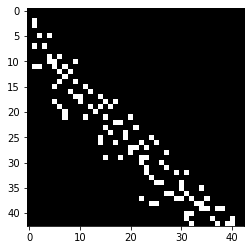

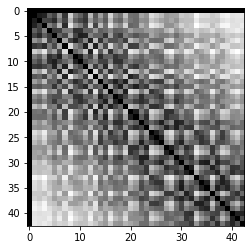

In [7]:
touch_matrix = cle.generate_touch_matrix(voronoi_diagram)

# igonore touching the background
cle.set_column(touch_matrix, 0, 0)


centroids = cle.centroids_of_labels(voronoi_diagram)

distance_matrix = cle.generate_distance_matrix(centroids, centroids)


cle.imshow(touch_matrix)
cle.imshow(distance_matrix)

Aus diesen beiden Matrizen können wir den minimalen und maximalen Abstand zwischen den Zentroiden von sich berührenden Objekten (Zellen) im Voronoi-Bild bestimmen. Dies sind geschätzte kleine und große Achsen der segmentierten Objekte.

In [8]:
min_distance = cle.minimum_distance_of_touching_neighbors(distance_matrix, touch_matrix)
max_distance = cle.maximum_distance_of_touching_neighbors(distance_matrix, touch_matrix)

print("Minimaler Abstand berührender Nachbarn", cle.mean_of_all_pixels(min_distance))
print("Maximaler Abstand berührender Nachbarn", cle.mean_of_all_pixels(max_distance))

minimum distance of touching neihbors 10.007136855014535
maximum distance of touching neihbors 16.39732325354288


## Distanzvisualisierung
Zum Schluss visualisieren wir die Abstände zwischen Nachbarn in einem farbigen Netz.

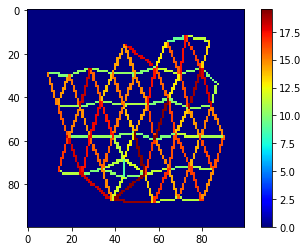

In [9]:
mesh = cle.draw_distance_mesh_between_touching_labels(voronoi_diagram)
cle.imshow(mesh, colorbar=True, colormap="jet")